# YAW pipeline testing 
To run this in production mode use `measure_yaw-w-random.py`.

In [1]:
# measure n(z)
import yaw
import os
import shutil
# check
import numpy as np
from astropy.io import fits
import pylab as pl

import healpy as hp

from yaw.correlation import autocorrelate_scalar, crosscorrelate_scalar
from yaw import autocorrelate
from yaw.utils import parallel
from yaw import crosscorrelate

import pandas as pd

from yaw.correlation.corrfunc import ScalarCorrFunc
import sys
sys.path.insert(0,"/global/homes/q/qhang/desi/lya/codes/")
import lya_utils as lu

In [2]:
njn=64
# here can test a range of scales
theta_min=[5,10,15]
theta_max=[15,30,50]
theta_scaled=None
resolution=None
unit='arcmin'

sim_mode_tag = "raw"
type_tag = "unknown"

ref_name = 'DELTA_F'
ref_weight_name = 'NPIX'

Delta F from raw catalog

In [3]:
sim_num = 0
unk_zcut = [1.8,3.0]

outroot = "/pscratch/sd/q/qhang/desi-lya/results/"

saveroot = outroot + f"run-{sim_num}/"
path_unknown = saveroot + f"catalogue/{type_tag}-zmin-{unk_zcut[0]}-zmax-{unk_zcut[1]}.fits"
path_reference = saveroot + f"catalogue/delta-{sim_mode_tag}.fits"
path_unk_rand = "/pscratch/sd/q/qhang/desi-lya/random-catalogue-overlap-w-z.fits"

In [4]:
print(path_unknown)

/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue/unknown-zmin-1.8-zmax-3.0.fits


In [5]:
# here use 40 bins, but we can test 20 bin case later:
edges = np.linspace(2,3,21)
zsamp = (edges[1:] + edges[:-1])/2.

In [6]:
fin = fits.open(path_unknown)
fin[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =            110938487 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z       '        

In [19]:
# turn on logging to terminal (can change level to "info" or remove this line entirely)
#get_logger(level="info", pretty=True, capture_warnings=True)
PROGRESS = True  # if you want to see a progress bar

# CONFIGURATION
patch_num = njn # code will generate this number of patch centers from the reference randoms
config = yaw.Configuration.create(
    rmin=theta_min,  # scalar or list of lower scale cuts
    rmax=theta_max,
    unit=unit,
    rweight=theta_scaled,
    resolution=resolution,
    edges=edges,
)

In [20]:
# LOADING CATALOGS
CACHE_DIR = saveroot + f"yaw-20bin/cache_{sim_mode_tag}"
#delete_and_recreate_cache_directory(CACHE_DIR)

In [9]:
# set up the catalogues:
cat_unknown = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "unknown"),
    path=path_unknown,
    ra_name="RA",
    dec_name="DEC",
    redshift_name="Z",
    #weight_name="weight_column",  # optional
    patch_num=patch_num,
    progress=PROGRESS,
    degrees=True,
)
patch_centers = cat_unknown.get_centers()

Process Process-66:t=0m00.00s
Traceback (most recent call last):
  File "/global/homes/q/qhang/.conda/envs/yaw_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/global/homes/q/qhang/.conda/envs/yaw_env/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/catalog/catalog.py", line 812, in task
    with CatalogWriter(
         ^^^^^^^^^^^^^^
  File "/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/catalog/catalog.py", line 453, in __init__
    raise FileExistsError(f"cache directory exists: {cache_directory}")
FileExistsError: cache directory exists: /pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-20bin/cache_raw/unknown
processed 7/7 (100%) t=0m08.53s
processed 64/64 (100%) t=0m01.30s


In [10]:
cat_reference = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "reference"),
    path=path_reference,
    ra_name="RA",
    dec_name="DEC",
    redshift_name="Z",
    weight_name=ref_weight_name,
    kappa_name=ref_name,
    patch_centers=patch_centers,
    progress=PROGRESS,
    degrees=True,
)

Process Process-196:=0m00.00s
Traceback (most recent call last):
  File "/global/homes/q/qhang/.conda/envs/yaw_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/global/homes/q/qhang/.conda/envs/yaw_env/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/catalog/catalog.py", line 812, in task
    with CatalogWriter(
         ^^^^^^^^^^^^^^
  File "/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/catalog/catalog.py", line 453, in __init__
    raise FileExistsError(f"cache directory exists: {cache_directory}")
FileExistsError: cache directory exists: /pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-20bin/cache_raw/reference
processed 1/1 (100%) t=0m01.19s
processed 64/64 (100%) t=0m01.31s


In [31]:
cat_reference = yaw.Catalog(cache_directory=os.path.join(CACHE_DIR, "reference"))

In [11]:
cat_ref_rand = None

In [21]:
cat_unk_rand = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "unk_rand"),
    path=path_unk_rand,
    ra_name="RA",
    dec_name="DEC",
    redshift_name="Z",
    patch_centers=patch_centers,
    progress=PROGRESS,
    degrees=True,
)

Process Process-582:t=0m00.00s
Traceback (most recent call last):
  File "/global/homes/q/qhang/.conda/envs/yaw_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/global/homes/q/qhang/.conda/envs/yaw_env/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/catalog/catalog.py", line 812, in task
    with CatalogWriter(
         ^^^^^^^^^^^^^^
  File "/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/catalog/catalog.py", line 453, in __init__
    raise FileExistsError(f"cache directory exists: {cache_directory}")
FileExistsError: cache directory exists: /pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-20bin/cache_raw/unk_rand
processed 11/11 (100%) t=0m18.37s
processed 64/64 (100%) t=0m01.53s


In [14]:
# measurements:
w_ss= autocorrelate_scalar(
    config,
    cat_reference,
    progress=PROGRESS
) # returns a list, one for each scale, just pick the first here
#   w_ss.to_file("...") -> store correlation pair counts as HDF5 file

processed 64/64 (100%) t=0m01.51s
processed 203/203 (100%) t=0m02.14s
processed 203/203 (100%) t=0m02.36s


/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


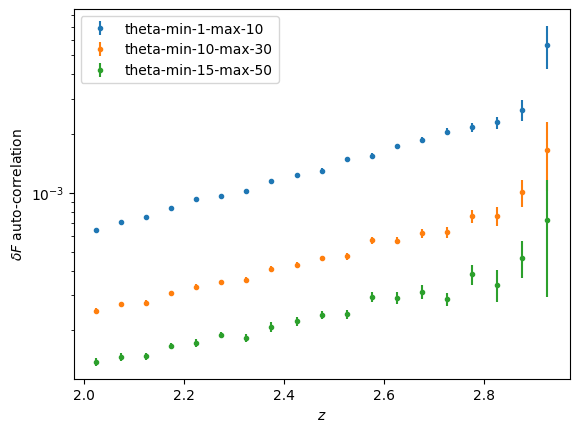

In [16]:
for ii in range(len(theta_min)):
    cts_ss = w_ss[ii]
    cts_ss.to_file(saveroot + f"yaw-20bin/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    cts_ss.sample().plot(label=f"theta-min-{theta_min[ii]}-max-{theta_max[ii]}")
    pl.xlabel("$z$")
    pl.ylabel("$\\delta F$ auto-correlation")
    pl.yscale('log')
    pl.legend()

In [22]:
w_sp = crosscorrelate_scalar(
    config,
    cat_reference,
    cat_unknown,
    unk_rand=cat_unk_rand,
    progress=True,  # shows a progress bar, default: False
)

processed 64/64 (100%) t=0m01.10s
processed 64/64 (100%) t=0m01.23s
processed 64/64 (100%) t=0m01.20s
processed 346/346 (100%) t=1m09.92s
processed 346/346 (100%) t=1m10.66s
processed 346/346 (100%) t=2m01.72s
processed 346/346 (100%) t=2m03.44s


/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


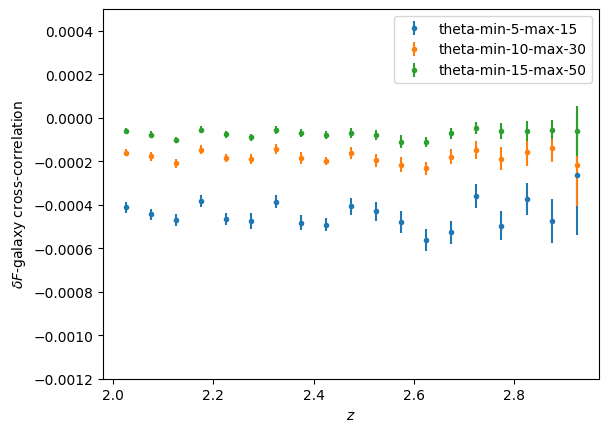

In [23]:
for ii in range(len(theta_min)):
    cts_sp = w_sp[ii]
    cts_sp.to_file(saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    cts_sp.sample().plot(label=f"theta-min-{theta_min[ii]}-max-{theta_max[ii]}")
    pl.xlabel("$z$")
    pl.ylabel("$\\delta F$-galaxy cross-correlation")
    #pl.yscale('log')
    pl.legend()
    pl.ylim([-0.0012,0.0005])

In [20]:
wppfname = saveroot + f"yaw-20bin/w_pp-theta-min-{theta_min[0]}-max-{theta_max[0]}.hdf5"
if os.path.isfile(wppfname)!=True:
    # also run unknown case:
    w_pp = autocorrelate(
        config,
        cat_unknown,
        random=cat_unk_rand,
        progress=PROGRESS
    )
    for ii in range(len(theta_min)):
        cts_pp = w_pp[ii]
        cts_pp.to_file(saveroot + f"yaw-20bin/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")

processed 64/64 (100%) t=0m04.13s
processed 64/64 (100%) t=0m06.04s
processed 205/205 (100%) t=1m06.42s
processed 346/346 (100%) t=1m30.09s
processed 205/205 (100%) t=2m11.89s


Text(0, 0.5, 'galaxy auto-correlation')

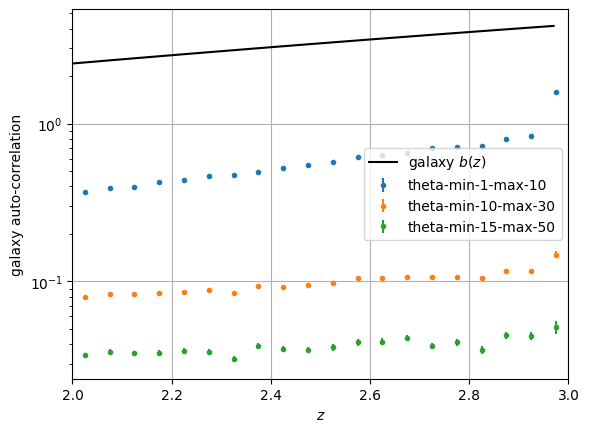

In [21]:
for ii in range(len(theta_min)):
    cts_pp = w_pp[ii]
    cts_pp.sample().plot(label=f"theta-min-{theta_min[ii]}-max-{theta_max[ii]}")

pl.yscale('log')
pl.grid()

# load and plot bias evolution curve:
bz = np.loadtxt("../bias_dc2.txt")
pl.plot(bz[:,0],bz[:,1],label="galaxy $b(z)$",color='k')
pl.xlim([2,3])

pl.legend()

pl.xlabel("$z$")
pl.ylabel("galaxy auto-correlation")

In [22]:
# load back the correlations:
w_ss=[]
w_sp=[]
w_pp=[]
for ii in range(len(theta_min)):
    fname = saveroot + f"yaw-20bin/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5"
    w_ss.append(ScalarCorrFunc.from_file(fname))

    fname = saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5"
    w_sp.append(ScalarCorrFunc.from_file(fname))

    fname = saveroot + f"yaw-20bin/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5"
    w_pp.append(yaw.CorrFunc.from_file(fname))

In [23]:
nz_true = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/nz-gal-z1.8-3.0-box-0-interp-for-rand.txt")
ind=(nz_true[:,1]>0)
nz_dz = nz_true[1,0] - nz_true[0,0]
nz_norm = (nz_true[:,1]/np.sum(nz_true[:,1])/nz_dz)[ind]
nz_zsamp = nz_true[ind,0]

Text(0.5, 1.0, '$n(z) = w_{\\rm ru}/\\sqrt{w_{\\rm rr} w_{\\rm uu}}\\Delta z$')

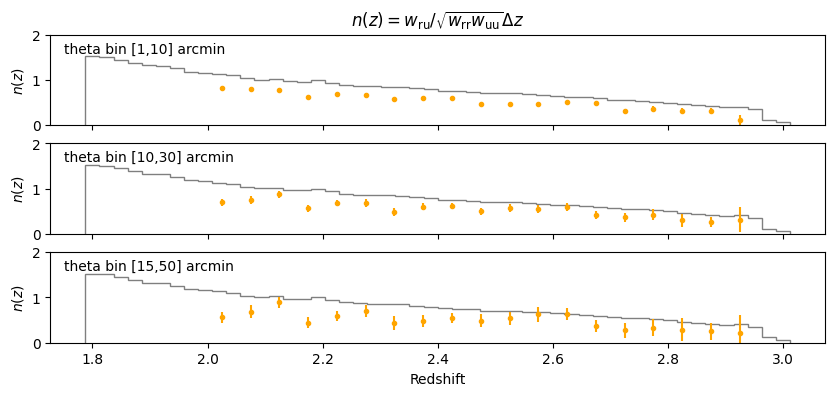

In [43]:
fig,axarr=pl.subplots(3,figsize=[10,4],sharex=True)

for ii in range(len(theta_min)):
    pl.sca(axarr[ii])
    
    cts_sp = w_sp[ii]
    cts_ss = w_ss[ii]
    cts_pp = w_pp[ii]
    
    zz = cts_sp.binning.mids
    sp = cts_sp.sample().data
    ss = cts_ss.sample().data
    pp = cts_pp.sample().data

    # get errorbar:
    samps = cts_sp.sample().samples/np.sqrt((cts_ss.sample().samples)*(cts_pp.sample().samples))
    std = np.std(samps,axis=0)*np.sqrt(64)
    
    deltaz = zz[1]-zz[0]
    pl.errorbar(zz, -sp/np.sqrt(ss*pp)/deltaz,yerr=std/deltaz,fmt='.',color='orange')
    
    # get true redshift distribution from sim:
    nz_edges = np.append(nz_zsamp-nz_dz/2., nz_zsamp[-1]+nz_dz/2.)
    pl.stairs(nz_norm,nz_edges, color='k', alpha=0.5)
    
    pl.ylabel("$n(z)$")
    pl.ylim([0,2])

    pl.text(1.75,1.6,f"theta bin [{theta_min[ii]},{theta_max[ii]}] arcmin")
pl.xlabel("Redshift")
pl.sca(axarr[0])
pl.title("$n(z) = w_{\\rm ru}/\\sqrt{w_{\\rm rr} w_{\\rm uu}}\\Delta z$")

Text(0.5, 1.0, '$n(z) \\propto w_{\\rm ru}/\\sqrt{w_{\\rm rr}}\\Delta z$')

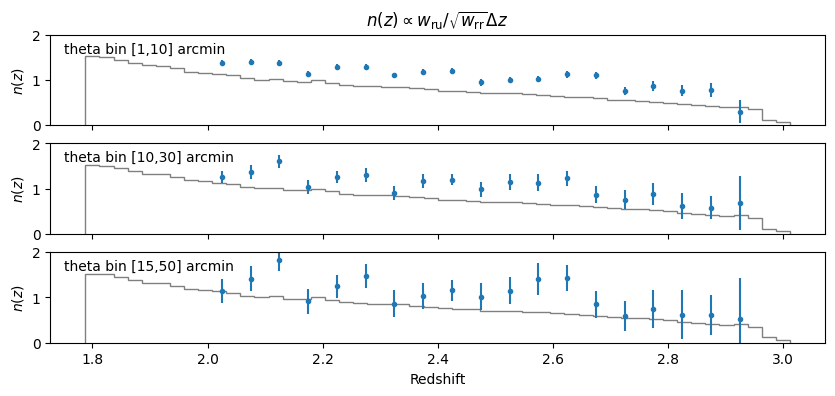

In [59]:
fig,axarr=pl.subplots(3,figsize=[10,4],sharex=True)

# here using yaw without the w_pp information:
for ii in range(len(theta_min)):
    pl.sca(axarr[ii])
    
    cts_sp = w_sp[ii]
    cts_ss = w_ss[ii]
    #cts_pp = w_pp[ii]
    ncc = yaw.RedshiftData.from_corrfuncs(
        cross_corr=cts_sp,
        ref_corr=cts_ss,
        unk_corr=None,
    )
    
    # or even with estimated normalisation
    ncc.normalised().plot()
    
    pl.ylabel("$n(z)$")
    pl.ylim([0,2])
    pl.text(1.75,1.6,f"theta bin [{theta_min[ii]},{theta_max[ii]}] arcmin")
    
    # get true redshift distribution from sim:
    nz_edges = np.append(nz_zsamp-nz_dz/2., nz_zsamp[-1]+nz_dz/2.)
    pl.stairs(nz_norm,nz_edges, color='k', alpha=0.5)
    #pl.stairs(cc[0]/sum(cc[0])/0.05, cc[1], color='k', alpha=0.5)
pl.xlabel("Redshift")
pl.sca(axarr[0])
pl.title("$n(z) \\propto w_{\\rm ru}/\\sqrt{w_{\\rm rr}}\\Delta z$")

## Without random

In [12]:
cat_unk_rand = None 

In [13]:
w_sp = crosscorrelate_scalar(
    config,
    cat_reference,
    cat_unknown,
    unk_rand=cat_unk_rand,
    progress=True,  # shows a progress bar, default: False
)

processed 64/64 (100%) t=0m01.23s
processed 64/64 (100%) t=0m01.15s
processed 346/346 (100%) t=1m10.55s
processed 346/346 (100%) t=1m09.70s


In [ ]:
for ii in range(len(theta_min)):
    cts_sp = w_sp[ii]
    cts_sp.to_file(saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-norand-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    cts_sp.sample().plot(label=f"theta-min-{theta_min[ii]}-max-{theta_max[ii]}")

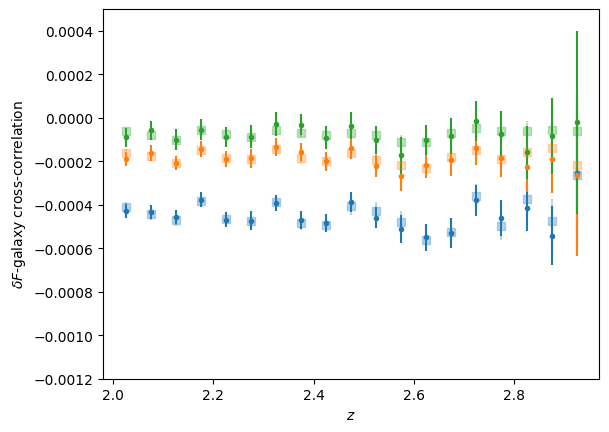

In [30]:
for ii in range(len(theta_min)):
    cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-norand-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    pl.errorbar(cts_sp.binning.mids, cts_sp.sample().data, yerr=cts_sp.sample().error, fmt='.')

    cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    pl.errorbar(cts_sp.binning.mids, cts_sp.sample().data, yerr=cts_sp.sample().error, fmt='s',color=f'C{ii}',alpha=0.3)
    
    pl.xlabel("$z$")
    pl.ylabel("$\\delta F$-galaxy cross-correlation")
    #pl.yscale('log')
    #pl.legend()
    pl.ylim([-0.0012,0.0005])

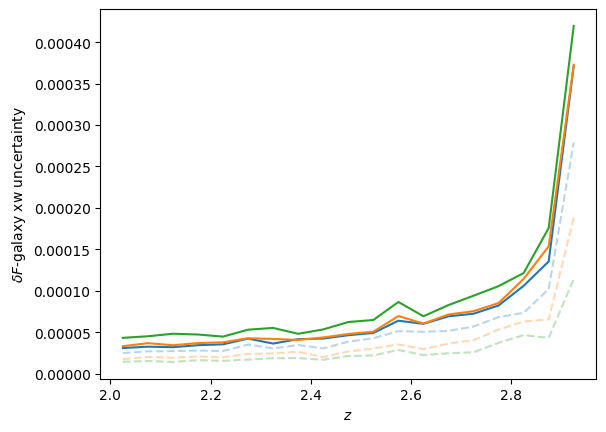

In [29]:
# let's compare their error bars here:
for ii in range(len(theta_min)):
    cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-norand-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    pl.plot(cts_sp.binning.mids, cts_sp.sample().error, '-')

    cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    pl.plot(cts_sp.binning.mids, cts_sp.sample().error, '--', color=f'C{ii}',alpha=0.3)
    pl.xlabel("$z$")
    pl.ylabel("$\\delta F$-galaxy xw uncertainty")
    #pl.yscale('log')
    #pl.ylim([-0.0012,0.0005])

# Compare to theory: save a txt file for yaw results:

### $w_{ss}$

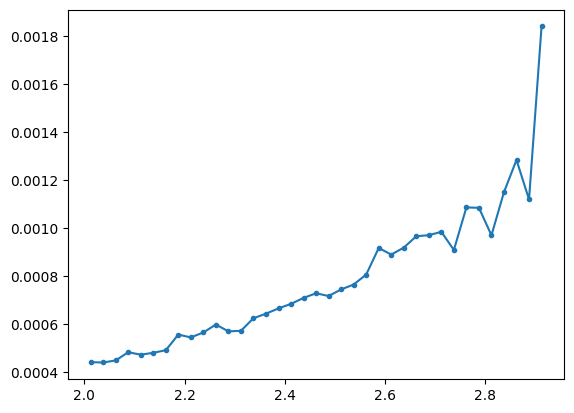

In [15]:
# load the w_ss for 40 and 20 bins:
sim_mode_tag="raw"
for ii in range(1,2):
    cts_ss = ScalarCorrFunc.from_file(saveroot + f"yaw/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    pl.plot(cts_ss.binning.mids[:-3], cts_ss.sample().data[:-3], '.-')

# save a version 
np.savetxt("mock0-wss-40bins-baseline-raw.txt",np.c_[cts_ss.binning.mids,cts_ss.sample().data,cts_ss.sample().error])

### $w_{pp}$
save all scales and all binning

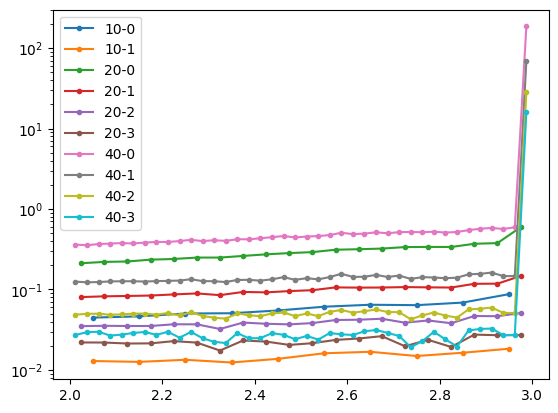

In [20]:
# load the w_ss for 40 and 20 bins:
outroot = "/pscratch/sd/q/qhang/desi-lya/results/"
saveroot = outroot + "run-0/"
theta_min=[5,10,15,30]
theta_max=[15,30,50,50]
for nbin, tag in zip([10,20,40],["-10bin","-20bin",""]):
    if nbin != 10:
        for ii in range(len(theta_min)):
            cts_ss = yaw.CorrFunc.from_file(saveroot + f"yaw{tag}/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
            if ii==0:
                out = np.c_[cts_ss.binning.mids,cts_ss.sample().data,cts_ss.sample().error]
            else:
                out = np.c_[out, cts_ss.sample().data,cts_ss.sample().error]
            pl.plot(cts_ss.binning.mids, cts_ss.sample().data, '.-', label=str(nbin)+"-"+str(ii))
    elif nbin == 10:
        for ii in range(2):
            cts_ss = yaw.CorrFunc.from_file(saveroot + f"yaw{tag}/w_pp-theta-min-{theta_min[ii*2+1]}-max-{theta_max[ii*2+1]}.hdf5")
            if ii==0:
                out = np.c_[cts_ss.binning.mids,cts_ss.sample().data,cts_ss.sample().error]
            else:
                out = np.c_[out, cts_ss.sample().data,cts_ss.sample().error]
            
            pl.plot(cts_ss.binning.mids, cts_ss.sample().data, '.-', label=str(nbin)+"-"+str(ii))
    # save a version 
    np.savetxt(f"mock0-wpp-{nbin}bins-baseline.txt",out)
pl.legend()
pl.yscale("log")

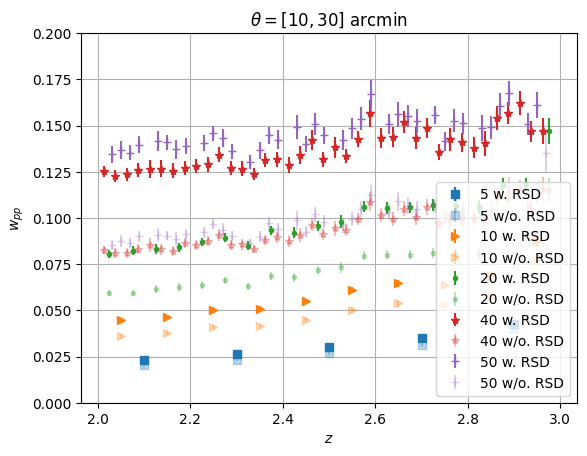

In [13]:
# here load no rsd and compare 
outroot = "/pscratch/sd/q/qhang/desi-lya/results/"
saveroot = outroot + "run-0/"
theta_min=[10]
theta_max=[30]
factor=1

for nbin, tag, fmt, color in zip([5,10,20,40,50],["-5bin","-10bin","-20bin","","-50bin"],
                                 ["s",">",".","*","+"],["C0", "C1","C2","C3","C4"]):
    for ii in range(len(theta_min)):
        cts_ss = yaw.CorrFunc.from_file(saveroot + f"yaw{tag}/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        pl.errorbar(cts_ss.binning.mids, cts_ss.sample().data, yerr=cts_ss.sample().error, fmt=fmt,
                    label=str(nbin)+" w. RSD", color=color, alpha=1)

        cts_ss = yaw.CorrFunc.from_file(saveroot + f"yaw{tag}/w_pp-norsd-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        pl.errorbar(cts_ss.binning.mids, cts_ss.sample().data*factor, yerr=cts_ss.sample().error*factor, fmt=fmt,
                label=str(nbin)+" w/o. RSD", color=color, alpha=0.3)
pl.legend()
#pl.yscale("log")
pl.ylim([0,0.2])
pl.xlabel("$z$")
pl.ylabel("$w_{pp}$")
pl.title("$\\theta = [10, 30]$ arcmin")
pl.grid()

In [12]:
# conver the file format to txt:
outroot = "/pscratch/sd/q/qhang/desi-lya/results/"
saveroot = outroot + "run-0/"
theta_min=[10]
theta_max=[30]
for nbin, tag in zip([5,10,20,40,50],["-5bin","-10bin","-20bin","","-50bin"]):
    for ii in range(len(theta_min)):
        cts_ss = yaw.CorrFunc.from_file(saveroot + f"yaw{tag}/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        out = np.c_[cts_ss.binning.mids, cts_ss.sample().data, cts_ss.sample().error]
        fname = saveroot + f"for_william/mock0-w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}-zbin-{nbin}.txt"
        np.savetxt(fname, out)

        cts_ss = yaw.CorrFunc.from_file(saveroot + f"yaw{tag}/w_pp-norsd-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        out = np.c_[cts_ss.binning.mids, cts_ss.sample().data, cts_ss.sample().error]
        fname = saveroot + f"for_william/mock0-w_pp-norsd-theta-min-{theta_min[ii]}-max-{theta_max[ii]}-zbin-{nbin}.txt"
        np.savetxt(fname, out)

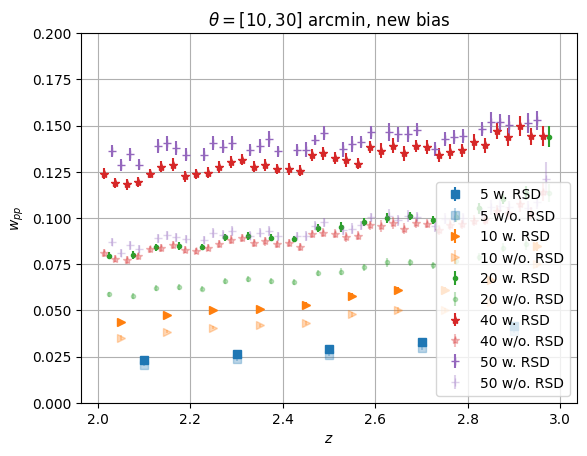

In [15]:
# same angular scale, new bias model:
outroot = "/pscratch/sd/q/qhang/desi-lya/results-newbias/"
saveroot = outroot + "run-0/"
theta_min=[10]
theta_max=[30]
factor=1

for nbin, tag, fmt, color in zip([5,10,20,40,50],["-5bin","-10bin","-20bin","","-50bin"],
                                 ["s",">",".","*","+"],["C0", "C1","C2","C3","C4"]):
    for ii in range(len(theta_min)):
        cts_ss = yaw.CorrFunc.from_file(saveroot + f"yaw{tag}/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        pl.errorbar(cts_ss.binning.mids, cts_ss.sample().data, yerr=cts_ss.sample().error, fmt=fmt,
                    label=str(nbin)+" w. RSD", color=color, alpha=1)

        cts_ss = yaw.CorrFunc.from_file(saveroot + f"yaw{tag}/w_pp-norsd-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        pl.errorbar(cts_ss.binning.mids, cts_ss.sample().data*factor, yerr=cts_ss.sample().error*factor, fmt=fmt,
                label=str(nbin)+" w/o. RSD", color=color, alpha=0.3)
pl.legend()
#pl.yscale("log")
pl.ylim([0,0.2])
pl.xlabel("$z$")
pl.ylabel("$w_{pp}$")
pl.title("$\\theta = [10, 30]$ arcmin, new bias")
pl.grid()

In [25]:
# conver the file format to txt:
outroot = "/pscratch/sd/q/qhang/desi-lya/results-newbias/"
saveroot = outroot + "run-0/"
theta_min=[10]
theta_max=[30]
for nbin, tag in zip([5,10,20,40,50],["-5bin","-10bin","-20bin","","-50bin"]):
    for ii in range(len(theta_min)):
        cts_ss = yaw.CorrFunc.from_file(saveroot + f"yaw{tag}/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        out = np.c_[cts_ss.binning.mids, cts_ss.sample().data, cts_ss.sample().error]
        fname = saveroot + f"for_william/mock0-w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}-zbin-{nbin}.txt"
        np.savetxt(fname, out)

        cts_ss = yaw.CorrFunc.from_file(saveroot + f"yaw{tag}/w_pp-norsd-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        out = np.c_[cts_ss.binning.mids, cts_ss.sample().data, cts_ss.sample().error]
        fname = saveroot + f"for_william/mock0-w_pp-norsd-theta-min-{theta_min[ii]}-max-{theta_max[ii]}-zbin-{nbin}.txt"
        np.savetxt(fname, out)

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:608: RuntimeWarning: invalid value encountered in divide
  data = counts.data / sum_weights.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:609: RuntimeWarning: invalid value encountered in divide
  samples = counts.samples / sum_weights.samples


In [18]:
# theta combined with rweight=0:
outroot = "/pscratch/sd/q/qhang/desi-lya/results/"
saveroot = outroot + "run-0/"
theta_min=[10]
theta_max=[30]
nbin = 20
tag = "-20bin"
cts_ss = yaw.CorrFunc.from_file(saveroot + f"yaw{tag}/w_pp-theta-min-{theta_min[0]}-max-{theta_max[0]}-rweight-0.hdf5")
out = np.c_[cts_ss.binning.mids, cts_ss.sample().data, cts_ss.sample().error]
fname = saveroot + f"for_william/mock0-w_pp-theta-min-{theta_min[0]}-max-{theta_max[0]}-zbin-{nbin}-rweight-0.txt"
np.savetxt(fname, out)

Text(0.5, 1.0, '$\\theta = [30, 50]$ arcmin')

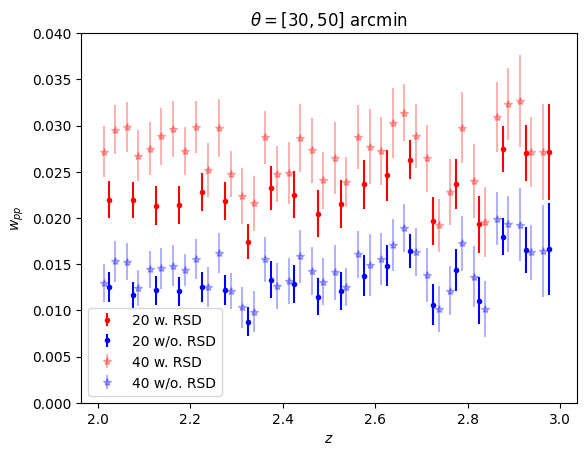

In [36]:
# here load no rsd and compare 
outroot = "/pscratch/sd/q/qhang/desi-lya/results/"
saveroot = outroot + "run-0/"
theta_min=[30]
theta_max=[50]
factor=1

for nbin, tag, fmt, alpha in zip([20,40],["-20bin",""],[".","*"],[1,0.3]):
    for ii in range(len(theta_min)):
        cts_ss = yaw.CorrFunc.from_file(saveroot + f"yaw{tag}/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        pl.errorbar(cts_ss.binning.mids, cts_ss.sample().data, yerr=cts_ss.sample().error, fmt=fmt,
                    label=str(nbin)+" w. RSD", color='r', alpha=alpha)

        cts_ss = yaw.CorrFunc.from_file(saveroot + f"yaw{tag}/w_pp-norsd-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        pl.errorbar(cts_ss.binning.mids, cts_ss.sample().data*factor, yerr=cts_ss.sample().error*factor, fmt=fmt,
                label=str(nbin)+" w/o. RSD", color='b', alpha=alpha)
pl.legend()
#pl.yscale("log")
pl.ylim([0,0.04])
pl.xlabel("$z$")
pl.ylabel("$w_{pp}$")
pl.title("$\\theta = [30, 50]$ arcmin")

In [8]:
# convert the file format to txt:
outroot = "/pscratch/sd/q/qhang/desi-lya/results/"
saveroot = outroot + "run-0/"
theta_min=[30]
theta_max=[50]
for nbin, tag in zip([20,40],["-20bin",""]):
    for ii in range(len(theta_min)):
        cts_ss = yaw.CorrFunc.from_file(saveroot + f"yaw{tag}/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        out = np.c_[cts_ss.binning.mids, cts_ss.sample().data, cts_ss.sample().error]
        fname = saveroot + f"for_william/mock0-w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}-zbin-{nbin}.txt"
        np.savetxt(fname, out)

        cts_ss = yaw.CorrFunc.from_file(saveroot + f"yaw{tag}/w_pp-norsd-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        out = np.c_[cts_ss.binning.mids, cts_ss.sample().data, cts_ss.sample().error]
        fname = saveroot + f"for_william/mock0-w_pp-norsd-theta-min-{theta_min[ii]}-max-{theta_max[ii]}-zbin-{nbin}.txt"
        np.savetxt(fname, out)

In [18]:
# can pull out the redshift difference:
fin = fits.open("/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue/unknown-zmin-1.8-zmax-3.0.fits")
z = fin[1].data['Z'][::100]
z_cosmo = fin[1].data['Z_COSMO'][::100]

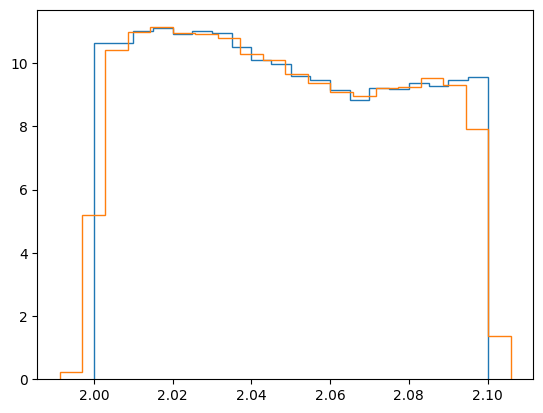

In [26]:
ind = (z>2)&(z<2.1)
cc = pl.hist(z[ind], bins=20,histtype='step',density=True)
cc = pl.hist(z_cosmo[ind], bins=20,histtype='step',density=True)

### $w_{sp}$

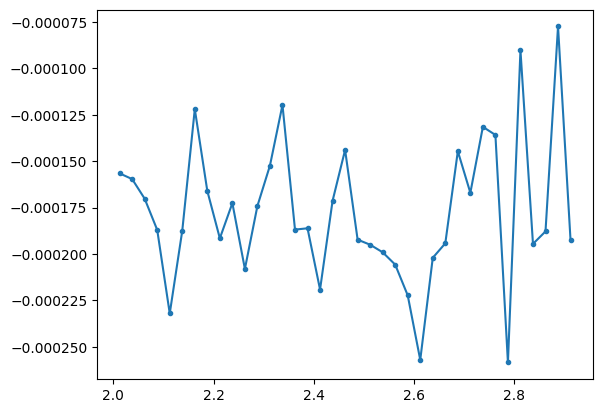

In [21]:
# load the w_ss for 40 and 20 bins:
for ii in range(1,2):
    cts_ss = ScalarCorrFunc.from_file(saveroot + f"yaw/w_sp-raw-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    pl.plot(cts_ss.binning.mids[:-3], cts_ss.sample().data[:-3], '.-')

# save a version 
np.savetxt("mock0-wsp-40bins-baseline-raw.txt",np.c_[cts_ss.binning.mids,cts_ss.sample().data,cts_ss.sample().error])

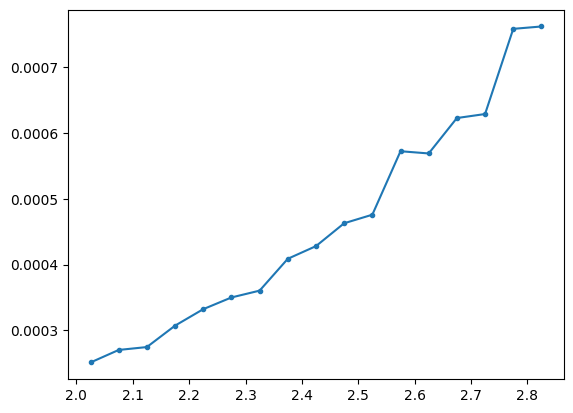

In [16]:
# load the w_ss for 40 and 20 bins:
sim_mode_tag="raw"
for ii in range(1,2):
    cts_ss = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    pl.plot(cts_ss.binning.mids[:-3], cts_ss.sample().data[:-3], '.-')

# save a version 
np.savetxt("mock0-wss-20bins-baseline-raw.txt",np.c_[cts_ss.binning.mids,cts_ss.sample().data,cts_ss.sample().error])

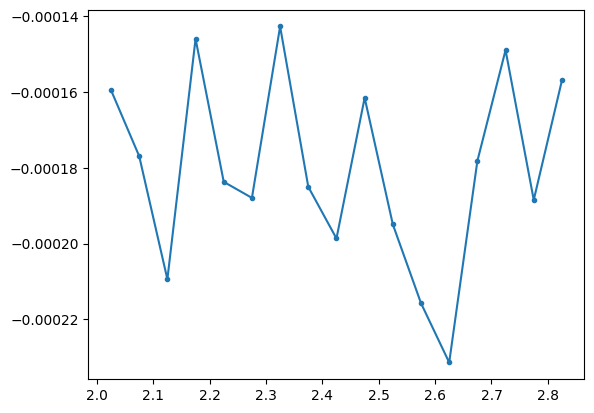

In [22]:
# load the w_ss for 40 and 20 bins:
for ii in range(1,2):
    cts_ss = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin/w_sp-raw-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    pl.plot(cts_ss.binning.mids[:-3], cts_ss.sample().data[:-3], '.-')

# save a version 
np.savetxt("mock0-wsp-20bins-baseline-raw.txt",np.c_[cts_ss.binning.mids,cts_ss.sample().data,cts_ss.sample().error])

In [48]:
sim_mode_tag="LyCAN_cont_noSNRcut"
path_reference = saveroot + f"catalogue/delta-{sim_mode_tag}.fits"

In [49]:
fin=fits.open(path_reference)

In [50]:
fin[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   64 / length of dimension 1                          
NAXIS2  =              4394543 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    8 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z       '        

In [14]:
fin[1].data['DELTA_F_WEIGHTED']

array([ 0.5274359 , -0.11928192,  0.48292071, ...,  0.19328964,
        0.15108972,  0.01462595], dtype='>f8')

In [16]:
fin[1].data['TOTWEIGHTS']

array([  5.34914873,   7.10081373,   8.70065633, ..., 217.27302733,
       239.33421548, 257.82323452], dtype='>f8')

In [57]:
sum(np.isnan(fin[1].data['TOTWEIGHTS']))

np.int64(0)

In [22]:
# load in the lya catalogue with yaw: 
CACHE_DIR = saveroot + f"yaw/cache_{sim_mode_tag}"

In [25]:
ref_weight_name

'NPIX'

In [26]:
ref_name

'DELTA_F'

In [46]:
cat_unknown = yaw.Catalog(cache_directory=os.path.join(CACHE_DIR, "unknown"))
patch_centers = cat_unknown.get_centers()

In [58]:
! rm -r /pscratch/sd/q/qhang/desi-lya/results/run-0/yaw/cache_LyCAN_cont_noSNRcut/reference

In [59]:
cat_reference = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "reference"),
    path=path_reference,
    ra_name="RA",
    dec_name="DEC",
    redshift_name="Z",
    weight_name='TOTWEIGHTS',
    kappa_name='DELTA_F_WEIGHTED',
    patch_centers=patch_centers,
    progress=PROGRESS,
    degrees=True,
)

processed 1/1 (100%) t=0m01.11s
processed 64/64 (100%) t=0m03.58s


In [37]:
sum(np.isnan(fin[1].data['DELTA_F_WEIGHTED'])),sum(np.isinf(fin[1].data['DELTA_F_WEIGHTED']))

(np.int64(91575), np.int64(0))

In [41]:
sum(np.isnan(fin[1].data['DELTA_F'])),sum(np.isinf(fin[1].data['DELTA_F']))

(np.int64(0), np.int64(0))

In [42]:
sum(np.isnan(fin[1].data['NPIX'])),sum(np.isinf(fin[1].data['NPIX']))

(np.int64(0), np.int64(0))

In [36]:
sum(np.isnan(fin[1].data['TOTWEIGHTS']))

np.int64(0)

In [43]:
path_reference

'/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue/delta-LyCAN_cont_noSNRcut.fits'

In [63]:
# need to fix the catalogue! 
keys = ['RA', 'DEC', 'Z', 'ZQSO', 'DELTA_F', 'DELTA_F_WEIGHTED', 'NPIX', 'TOTWEIGHTS']
for sim_num in range(1):
    path_reference = f'/pscratch/sd/q/qhang/desi-lya/results/run-{sim_num}/catalogue-20bin/delta-LyCAN_cont_noSNRcut.fits'
    fin = fits.open(path_reference)
    ind = ~np.isnan(fin[1].data['DELTA_F_WEIGHTED'])

    data_matrix = {}
    for key in keys:
        data_matrix[key] = fin[1].data[key][ind]
    print(len(data_matrix[key]))
    lu.save_catalog_to_fits(path_reference, data_matrix, overwrite=True)
    print("saved: ", path_reference)

2323408
saved:  /pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue-20bin/delta-LyCAN_cont_noSNRcut.fits


### plot randoms

In [5]:
rand = fits.open(path_unk_rand)

In [6]:
rand[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   48 / length of dimension 1                          
NAXIS2  =            169985370 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    6 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z       '        

In [69]:
ra = rand[1].data['RA'][::10]
dec = rand[1].data['DEC'][::10]
nside=1024
pix = hp.ang2pix(nside, ra, dec, lonlat=True)
rand_map = np.bincount(pix, minlength = int(12*nside**2))

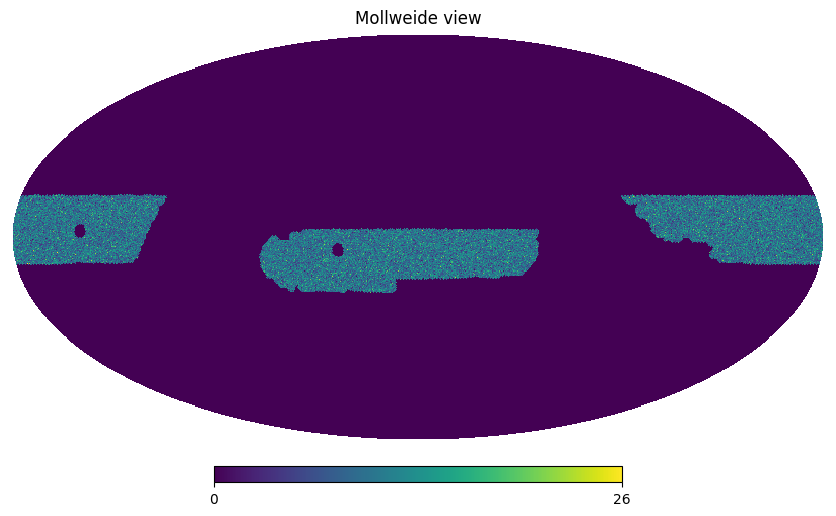

In [70]:
hp.mollview(rand_map)

In [7]:
fin_data = fits.open(path_unknown)
nz_baseline = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/nz-gal-z1.8-3.0-all-boxes.txt")

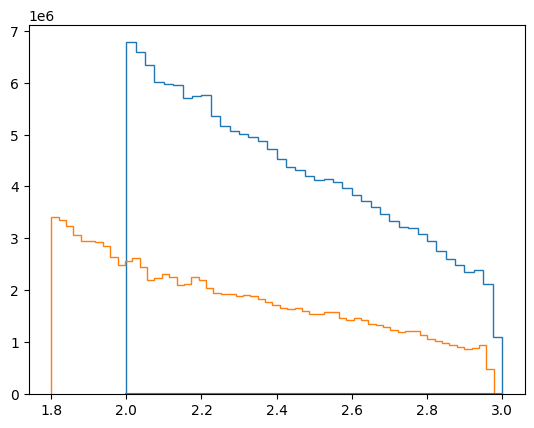

In [13]:
z = rand[1].data['Z']
z_data = fin_data[1].data['Z']
cc1=pl.hist(z,bins=40, histtype='step')
cc=pl.hist(z_data,bins=60, histtype='step')
pl.plot(nz_baseline[:,0], nz_baseline[:,1])

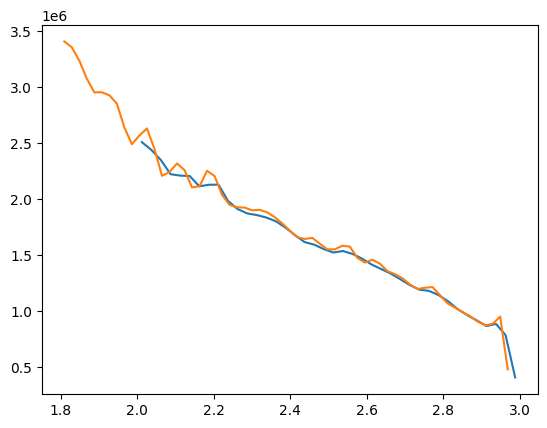

In [26]:
pl.plot((cc1[1][1:]+cc1[1][:-1])/2, cc1[0]/2.7)
pl.plot((cc[1][1:]+cc[1][:-1])/2, cc[0])

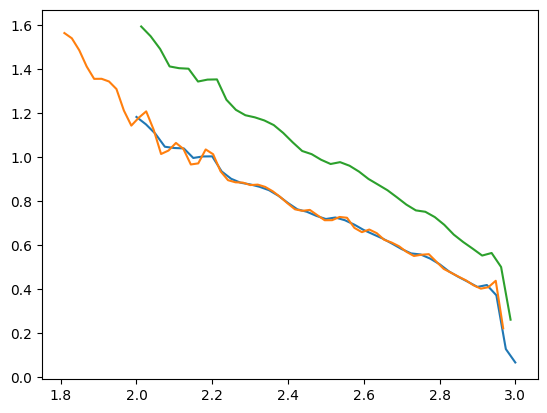

In [17]:
pl.plot(nz_baseline[:,0],nz_baseline[:,1])
pl.plot((cc[1][1:]+cc[1][:-1])/2, cc[0]/sum(cc[0])/(cc[1][1]-cc[1][0]))
pl.plot((cc1[1][1:]+cc1[1][:-1])/2, cc1[0]/sum(cc1[0])/(cc1[1][1]-cc1[1][0]))

# Measure the $C_{\ell}$ for the old and new bias to see difference

In [16]:
outroot = "/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue/"
map1 = hp.read_map(outroot + "galmap-unknown-zmin-1.8-zmax-3.0.fits")
cell1 = hp.anafast(map1)

In [20]:
outroot = "/pscratch/sd/q/qhang/desi-lya/results-newbias/run-0/catalogue/"
map2= hp.read_map(outroot + "galmap-unknown-zmin-1.8-zmax-3.0.fits")
cell2 = hp.anafast(map2)

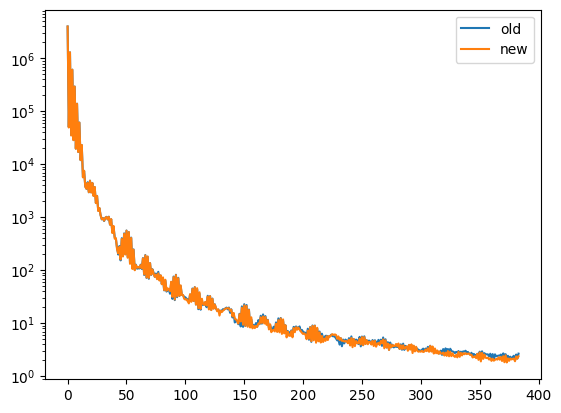

In [24]:
pl.semilogy(cell1,label="old")
pl.semilogy(cell2,label="new")
pl.legend()

# Measure the QSO-galaxy correlation

In [4]:
outroot = "/pscratch/sd/q/qhang/desi-lya/results/"
sim_num = 0
type_tag = "unknown"
unk_tag = ""
unk_zcut=[1.8,3.0]
ref_tag = "-20bin"
sim_mode_tag = "raw"
yaw_tag = "-20bin"
rand_z_name = "Z"

In [5]:
saveroot = outroot + f"run-{sim_num}/"
path_unknown = saveroot + f"catalogue/{type_tag}{unk_tag}-zmin-{unk_zcut[0]}-zmax-{unk_zcut[1]}.fits"
path_reference = saveroot + f"catalogue{ref_tag}/delta-{sim_mode_tag}.fits"
path_unk_rand = "/pscratch/sd/q/qhang/desi-lya/random-catalogue-overlap-w-z.fits"

In [20]:
zbins = [2,3,20]
edges = np.linspace(float(zbins[0]), float(zbins[1]), int(zbins[2])+1)
zsamp = (edges[1:] + edges[:-1])/2.

In [21]:
# turn on logging to terminal (can change level to "info" or remove this line entirely)
#get_logger(level="info", pretty=True, capture_warnings=True)
PROGRESS = True  # if you want to see a progress bar

# CONFIGURATION
patch_num = njn # code will generate this number of patch centers from the reference randoms
config = yaw.Configuration.create(
    rmin=theta_min,  # scalar or list of lower scale cuts
    rmax=theta_max,
    unit=unit,
    rweight=theta_scaled,
    resolution=resolution,
    edges=edges,
)

# LOADING CATALOGS
CACHE_DIR = saveroot + f"yaw{yaw_tag}/cache_{sim_mode_tag}-QSO/"
print("cache: ", CACHE_DIR)

delete_and_recreate_cache_directory(CACHE_DIR)

# set up the catalogues:
cat_unknown = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "unknown"),
    path=path_unknown,
    ra_name="RA",
    dec_name="DEC",
    redshift_name="Z",
    #weight_name="weight_column",  # optional
    patch_num=patch_num,
    progress=PROGRESS,
    degrees=True,
)
patch_centers = cat_unknown.get_centers()


cat_reference = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "reference"),
    path=path_reference,
    ra_name="RA",
    dec_name="DEC",
    redshift_name="Z",
    #weight_name=ref_weight_name,
    #kappa_name=ref_name,
    patch_centers=patch_centers,
    progress=PROGRESS,
    degrees=True,
)

cat_ref_rand = None 
cat_unk_rand = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "unk_rand"),
    path=path_unk_rand,
    ra_name="RA",
    dec_name="DEC",
    redshift_name=rand_z_name,
    patch_centers=patch_centers,
    progress=PROGRESS,
    degrees=True,
)

print("Done loading catalogues")

cache:  /pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-20bin/cache_raw-QSO/


processed 7/7 (100%) t=0m10.24s
processed 64/64 (100%) t=0m02.28s
processed 1/1 (100%) t=0m00.59s
processed 64/64 (100%) t=0m01.47s
processed 11/11 (100%) t=0m20.82s
processed 64/64 (100%) t=0m02.77s


Done loading catalogues


In [22]:
print("Computing w_sp")
w_sp = crosscorrelate(
    config,
    cat_reference,
    cat_unknown,
    ref_rand=cat_unk_rand,
    progress=PROGRESS
)

processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m01.41s
processed 64/64 (100%) t=0m06.48s
processed 64/64 (100%) t=0m04.10s
processed 346/346 (100%) t=1m15.99s
processed 346/346 (100%) t=39m54.99s


In [33]:
# load results:
w_sp= []
for ii in range(len(theta_min)):
    cts_pp = yaw.CorrFunc.from_file(saveroot + f"yaw-20bin/w_sp-QSO-raw-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    w_sp.append(cts_pp)

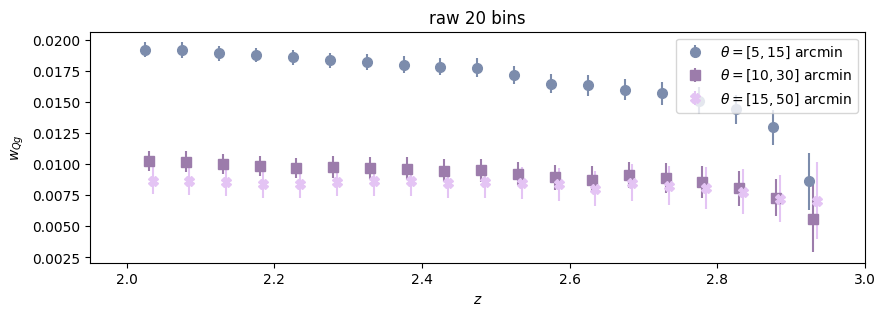

In [35]:
fig,axarr=pl.subplots(figsize=[10,3])
fmt=['o','s','X']
color=['#7c8cac','#9c7cab','#e4c4f4']
#label=["Picca", "LyCAN"]
Nbins=20

mode = "raw"
for jj in range(len(theta_min)):
    label = f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin"
    pl.errorbar(zsamp + jj*0.005, w_sp[jj].sample().data, 
               yerr = w_sp[jj].sample().error, fmt=fmt[jj], label=label,color=color[jj],markersize=7)
pl.title(mode + f" {Nbins} bins")


#pl.plot([1.8,3.0],[1,1],'k-')
#pl.stairs(nz_norm,nz_edges, color='k', label='truth')
pl.xlim([1.95,3.0])
#pl.ylim([0.6, 1.1])

pl.legend()
pl.xlabel("$z$")
pl.ylabel("$w_{Qg}$")
pl.savefig("../plots/w_Qg-scales-20bin-raw.pdf", bbox_inches="tight")

In [ ]:
# need to rerun above to save things

# Meausre corss-corrleation within a bin:

In [20]:
outroot = "/pscratch/sd/q/qhang/desi-lya/results/"
sim_num = 0
type_tag = "unknown"
unk_tag = ""
unk_zcut=[1.8,3.0]
Nbins=[40,20]
ref_tag = ["", "-20bin"]
sim_mode_tag = "raw"
yaw_tag = ["", "-20bin"]
rand_z_name = "Z"

In [5]:
saveroot = outroot + f"run-{sim_num}/"
path_unknown = saveroot + f"catalogue/{type_tag}{unk_tag}-zmin-{unk_zcut[0]}-zmax-{unk_zcut[1]}.fits"
path_reference = saveroot + f"catalogue{ref_tag[0]}/delta-{sim_mode_tag}.fits"
path_unk_rand = "/pscratch/sd/q/qhang/desi-lya/random-catalogue-overlap-w-z.fits"

In [6]:
edges=[]
zsamp=[]
for ii, nb in enumerate(Nbins):
    zbins=[2,3,nb]
    edges.append(np.linspace(float(zbins[0]), float(zbins[1]), int(zbins[2])+1))
    zsamp.append((edges[ii][1:] + edges[ii][:-1])/2.)

In [7]:
# load unknown data
fin = fits.open(path_unknown)
unknownz = fin[1].data['Z']
unknownz_bin = np.digitize(unknownz, edges)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [10]:
# load the cross-correlation results:
W_SP = []
for jj, nb in enumerate(Nbins):
    w_sp_theta = {}
    for ii in range(len(theta_min)):
        fname = saveroot + f"yaw{yaw_tag[jj]}/w_sp-zbins-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.txt"
        fin = np.loadtxt(fname)
        w_sp_theta[ii] = fin[:,1:]
    W_SP.append(w_sp_theta)

In [23]:
# load the cross-correlation results:
W_SP_CC = []
for jj, nb in enumerate(Nbins):
    w_sp_theta = {}
    for ii in range(len(theta_min)):
        fname = saveroot + f"yaw{yaw_tag[jj]}/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5"
        fin = yaw.ScalarCorrFunc.from_file(fname)
        w_sp_theta[ii] = np.c_[fin.sample().data, fin.sample().error]
    W_SP_CC.append(w_sp_theta)

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


Text(0, 0.5, '$w_{sp}$ in zbins')

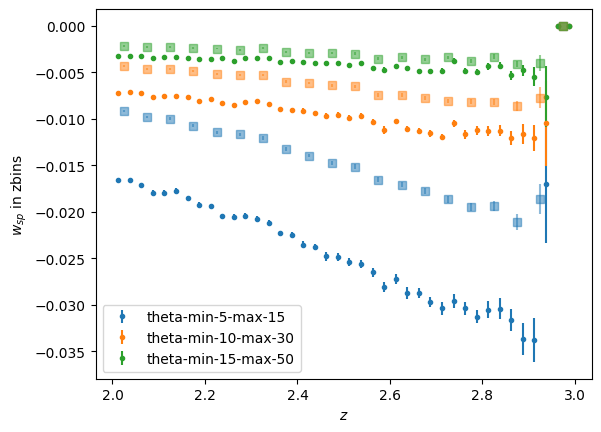

In [14]:
fmt = ['.','s']
alpha=[1,0.5]
for jj, nb in enumerate(Nbins):
    w_sp_theta = W_SP[jj]
    for ii in range(len(theta_min)):
        if jj == 0:
            label=f"theta-min-{theta_min[ii]}-max-{theta_max[ii]}"
        else:
            label=""
        pl.errorbar(zsamp[jj], w_sp_theta[ii][:,0], yerr=w_sp_theta[ii][:,1], fmt=fmt[jj], 
                    label=label, color=f"C{ii}",alpha=alpha[jj])
        
pl.legend()
pl.xlabel("$z$")
pl.ylabel("$w_{sp}$ in zbins")

(-0.04, 0.002)

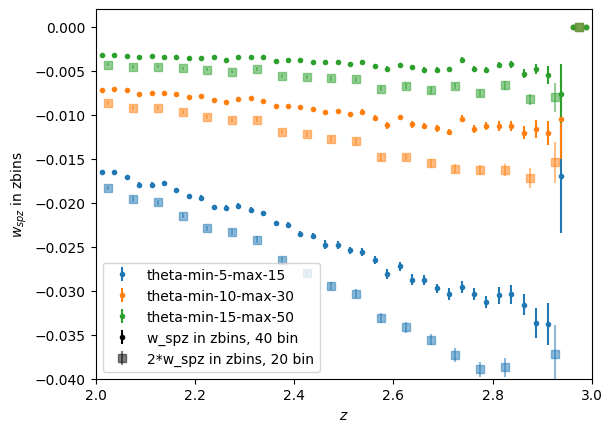

In [36]:
fmt = ['.','s']
alpha=[1,0.5]
for jj, nb in enumerate(Nbins):
    w_sp_theta = W_SP[jj]
    for ii in range(len(theta_min)):
        if jj == 0:
            label=f"theta-min-{theta_min[ii]}-max-{theta_max[ii]}"
        else:
            label=""
        pl.errorbar(zsamp[jj], w_sp_theta[ii][:,0]*(jj+1), yerr=w_sp_theta[ii][:,1]*(jj+1), fmt=fmt[jj], 
                    label=label, color=f"C{ii}",alpha=alpha[jj])

# add some labels:
for jj in range(2):
    if jj==0:
        label="w_spz in zbins, 40 bin"
    if jj==1:
        label="2*w_spz in zbins, 20 bin"
    pl.errorbar([1], [1], yerr=[0], fmt=fmt[jj],
                label=label, color='k',alpha=alpha[jj])
pl.legend()
pl.xlabel("$z$")
pl.ylabel("$w_{spz}$ in zbins")
pl.xlim([2,3])
pl.ylim([-0.04,0.002])

(-0.001, 0.0001)

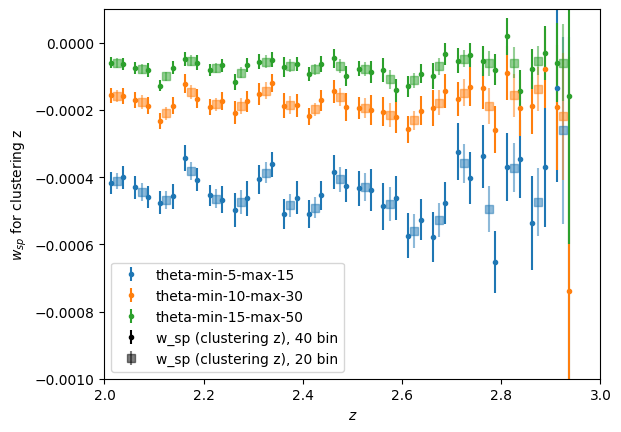

In [35]:
# plot the w_sp for CC here for comparison:
fmt = ['.','s']
alpha=[1,0.5]
for jj, nb in enumerate(Nbins):
    w_sp_theta = W_SP_CC[jj]
    for ii in range(len(theta_min)):
        if jj == 0:
            label=f"theta-min-{theta_min[ii]}-max-{theta_max[ii]}"
        else:
            label=""
        pl.errorbar(zsamp[jj], w_sp_theta[ii][:,0], yerr=w_sp_theta[ii][:,1], fmt=fmt[jj], 
                    label=label, color=f"C{ii}",alpha=alpha[jj])
        
# add some labels:
for jj in range(2):
    if jj==0:
        label="w_sp (clustering z), 40 bin"
    if jj==1:
        label="w_sp (clustering z), 20 bin"
    pl.errorbar([1], [1], yerr=[0], fmt=fmt[jj],
                label=label, color='k',alpha=alpha[jj])

pl.legend()
pl.xlabel("$z$")
pl.ylabel("$w_{sp}$ for clustering z")
pl.xlim([2,3])
pl.ylim([-0.001,0.0001])

In [15]:
def simple_corr_error_comb(w_sp, w_pp, w_ss):
    f1 = w_sp[:,1]/w_sp[:,0]
    f2 = w_ss[:,1]/w_ss[:,0]
    f3 = w_pp[:,1]/w_pp[:,0]
    f4 = np.sqrt(f1**2 + 0.5*(f2**2 + f3**2))
    r = w_sp[:,0]/np.sqrt(w_ss[:,0]*w_pp[:,0])
    return np.c_[r, r*f4]

In [16]:
# let's load the auto-correlations:
ERROR_R=[]
for jj, nb in enumerate(Nbins):
    w_ss_theta = []
    w_pp_theta = []
    w_sp_theta = []
    for ii in range(len(theta_min)):
        cts_ss = ScalarCorrFunc.from_file(saveroot + f"yaw{yaw_tag[jj]}/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        cts_pp = yaw.CorrFunc.from_file(saveroot + f"yaw{yaw_tag[jj]}/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        fin = np.loadtxt(saveroot + f"yaw{yaw_tag[jj]}/w_sp-zbins-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.txt")
        
        w_ss_theta.append(cts_ss)
        w_pp_theta.append(cts_pp)
        w_sp_theta.append(fin[:,1:])

    # then get error:
    error_r = []
    for ii in range(len(theta_min)):
        a = np.c_[w_ss_theta[ii].sample().data, w_ss_theta[ii].sample().error]
        b = np.c_[w_pp_theta[ii].sample().data, w_pp_theta[ii].sample().error]
        c = w_sp_theta[ii]
        error_r.append(simple_corr_error_comb(c, a, b))

    ERROR_R.append(error_r)

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples
/tmp/ipykernel_1091585/3713362444.py:2: RuntimeWarning: invalid value encountered in divide
  f1 = w_sp[:,1]/w_sp[:,0]
/tmp/ipykernel_1091585/3713362444.py:6: RuntimeWarning: invalid value encountered in sqrt
  r = w_sp[:,0]/np.sqrt(w_ss[:,0]*w_pp[:,0])


Text(0, 0.5, 'Correlation coefficient $r_{Fg}$')

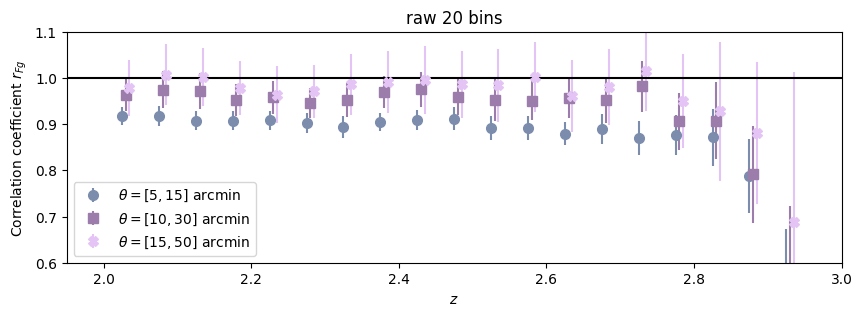

In [17]:
fig,axarr=pl.subplots(figsize=[10,3])
fmt=['o','s','X']
color=['#7c8cac','#9c7cab','#e4c4f4']
#label=["Picca", "LyCAN"]
Nbins=20
error_r = ERROR_R[1]

mode = "raw"
for jj in range(len(theta_min)):
    label = f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin"
    pl.errorbar(zsamp[1] + jj*0.005, abs(error_r[jj][:,0]), yerr=abs(error_r[jj][:,1]),
                        fmt=fmt[jj], label=label,color=color[jj],markersize=7)
pl.title(mode + f" {Nbins} bins")


pl.plot([1.8,3.0],[1,1],'k-')
#pl.stairs(nz_norm,nz_edges, color='k', label='truth')
pl.xlim([1.95,3.0])
pl.ylim([0.6, 1.1])

pl.legend()
pl.xlabel("$z$")
pl.ylabel("Correlation coefficient $r_{Fg}$")

#pl.savefig("../plots/corr-coeff-scales-20bin-raw.pdf", bbox_inches="tight")

Text(0, 0.5, 'Correlation coefficient $r_{Fg}$')

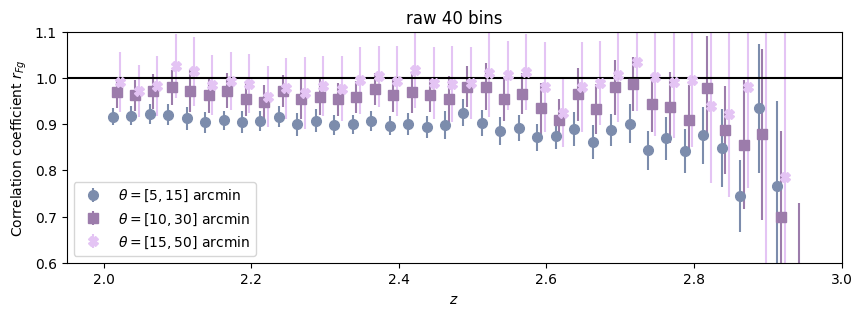

In [18]:
fig,axarr=pl.subplots(figsize=[10,3])
fmt=['o','s','X']
color=['#7c8cac','#9c7cab','#e4c4f4']
#label=["Picca", "LyCAN"]
Nbins=40
error_r = ERROR_R[0]

mode = "raw"
for jj in range(len(theta_min)):
    label = f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin"
    pl.errorbar(zsamp[0] + jj*0.005, abs(error_r[jj][:,0]), yerr=abs(error_r[jj][:,1]),
                        fmt=fmt[jj], label=label,color=color[jj],markersize=7)
pl.title(mode + f" {Nbins} bins")


pl.plot([1.8,3.0],[1,1],'k-')
#pl.stairs(nz_norm,nz_edges, color='k', label='truth')
pl.xlim([1.95,3.0])
pl.ylim([0.6, 1.1])

pl.legend()
pl.xlabel("$z$")
pl.ylabel("Correlation coefficient $r_{Fg}$")

#pl.savefig("../plots/corr-coeff-scales-20bin-raw.pdf", bbox_inches="tight")